mounting drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/tea sickness dataset.zip" -d "DataSet"

Archive:  /content/drive/MyDrive/tea sickness dataset.zip
   creating: DataSet/tea sickness dataset/
   creating: DataSet/tea sickness dataset/white spot/
  inflating: DataSet/tea sickness dataset/white spot/UNADJUSTEDNONRAW_thumb_e3.jpg  
   creating: DataSet/__MACOSX/
   creating: DataSet/__MACOSX/tea sickness dataset/
   creating: DataSet/__MACOSX/tea sickness dataset/white spot/
  inflating: DataSet/__MACOSX/tea sickness dataset/white spot/._UNADJUSTEDNONRAW_thumb_e3.jpg  
  inflating: DataSet/tea sickness dataset/white spot/UNADJUSTEDNONRAW_thumb_d7.jpg  
  inflating: DataSet/__MACOSX/tea sickness dataset/white spot/._UNADJUSTEDNONRAW_thumb_d7.jpg  
  inflating: DataSet/tea sickness dataset/white spot/UNADJUSTEDNONRAW_thumb_ee.jpg  
  inflating: DataSet/__MACOSX/tea sickness dataset/white spot/._UNADJUSTEDNONRAW_thumb_ee.jpg  
  inflating: DataSet/tea sickness dataset/white spot/UNADJUSTEDNONRAW_thumb_da.jpg  
  inflating: DataSet/__MACOSX/tea sickness dataset/white spot/._UNADJUS

In [5]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import splitfolders

splitfolders.ratio("/content/DataSet/tea sickness dataset", output="/content/Images",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 885 files [00:02, 327.09 files/s]


In [7]:
import os
from tqdm.notebook import tqdm_notebook as tqdm
import cv2
import numpy as np
import pandas as pd
from glob import glob
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.utils import np_utils
import tensorflow as tf
import keras
from keras.applications.mobilenet import MobileNet, preprocess_input

from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [8]:
CLASS = {
    'Anthracnose': 0,
    'algal leaf': 1,
    'bird eye spot': 2,
    'brown blight': 3,
    'gray light': 4,
    'healthy': 5,
    'red leaf spot': 6,
    'white spot': 7,
}

INV_CLASS = {CLASS[j]:j for j in CLASS}

In [9]:
def preprop_img(image_path, verbose=0):
    if verbose:
        print(image_path)
    img=cv2.imread(image_path)
    img=cv2.resize(img, (128,128))
    return img

In [10]:
train_image=[]
train_label=[]
BASE='/content/Images/train'
for i in tqdm(os.listdir(BASE), total=len(CLASS)):
    for j in os.listdir(os.path.join(BASE,i)):
        train_image.append(preprop_img(os.path.join(BASE,i,j)))
        train_label.append(CLASS[i])
train_image=np.array(train_image)
train_label=np.array(train_label)

print("Shape of train_image:",train_image.shape,"Shape of train_label:",train_label.shape)

  0%|          | 0/8 [00:00<?, ?it/s]

Shape of train_image: (706, 128, 128, 3) Shape of train_label: (706,)


In [11]:
test_image=[]
test_label=[]
BASE='/content/Images/test'
for i in tqdm(os.listdir(BASE), total=len(CLASS)):
    for j in os.listdir(os.path.join(BASE,i)):
        test_image.append(preprop_img(os.path.join(BASE,i,j)))
        test_label.append(CLASS[i])
test_image=np.array(test_image)
test_label=np.array(test_label)

print("Shape of train_image:",test_image.shape,"Shape of train_label:",test_label.shape)

  0%|          | 0/8 [00:00<?, ?it/s]

Shape of train_image: (92, 128, 128, 3) Shape of train_label: (92,)


In [12]:
train_label_cat = np_utils.to_categorical(train_label,len(CLASS))
print(train_label_cat.shape)

(706, 8)


In [13]:
test_label_cat = np_utils.to_categorical(test_label,len(CLASS))
print(test_label_cat.shape)

(92, 8)


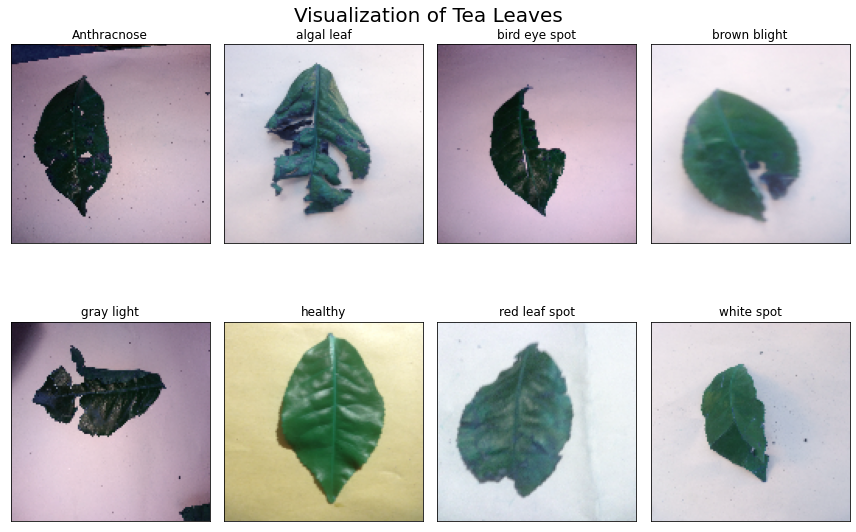

In [14]:
plt.figure(figsize=(12,12))

for i in range(8):  
    
    plt.subplot(3,4,i+1)
    
    index = np.where(train_label==i)[0][1]
    plt.imshow(train_image[index])
    plt.title(INV_CLASS[np.argmax(train_label_cat[index])])
    plt.xticks([]), plt.yticks([])

plt.suptitle("Visualization of Tea Leaves", fontsize=20)    
plt.tight_layout()
plt.show()

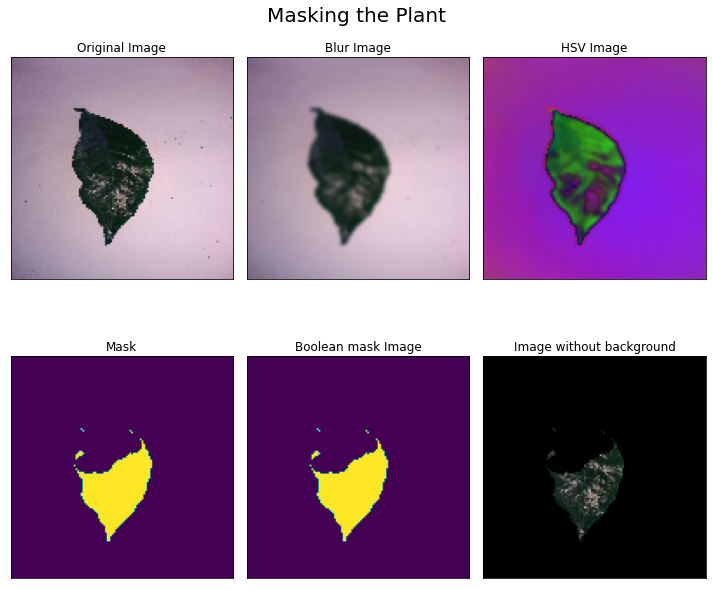

In [15]:
clearTrainImg = []
examples = []; getEx = True
plt.figure(figsize=(10,9))

for img in train_image:
    
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTrainImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.xticks([]), plt.yticks([]), plt.title("Original Image")
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.xticks([]), plt.yticks([]), plt.title("Blur Image")
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.xticks([]), plt.yticks([]), plt.title("HSV Image")
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.xticks([]), plt.yticks([]), plt.title("Mask")
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.xticks([]), plt.yticks([]), plt.title("Boolean mask Image")
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        plt.xticks([]), plt.yticks([]), plt.title("Image without background")
        getEx = False
plt.suptitle("Masking the Plant", fontsize=20)
plt.tight_layout()    

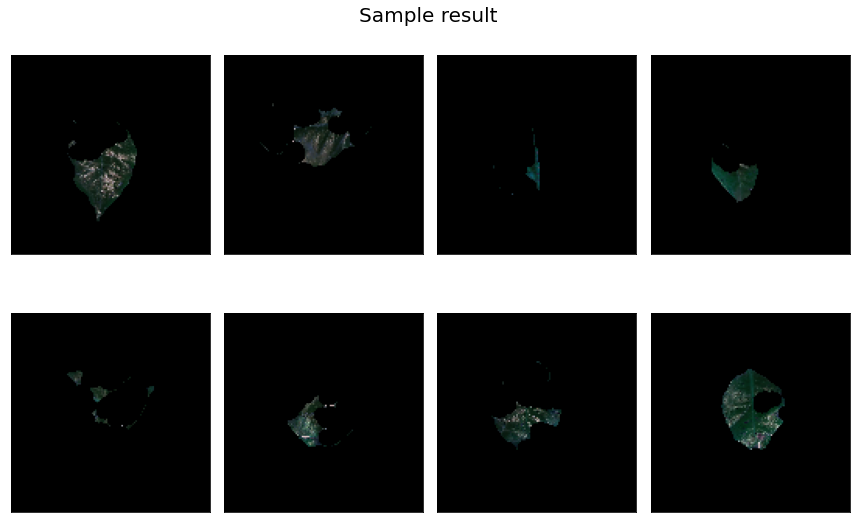

In [16]:
clearTrainImg = np.asarray(clearTrainImg)
plt.figure(figsize=(12,8))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg[i])
    plt.xticks([]), plt.yticks([])
    
plt.suptitle("Sample result", fontsize=20)  
plt.tight_layout()
plt.show()

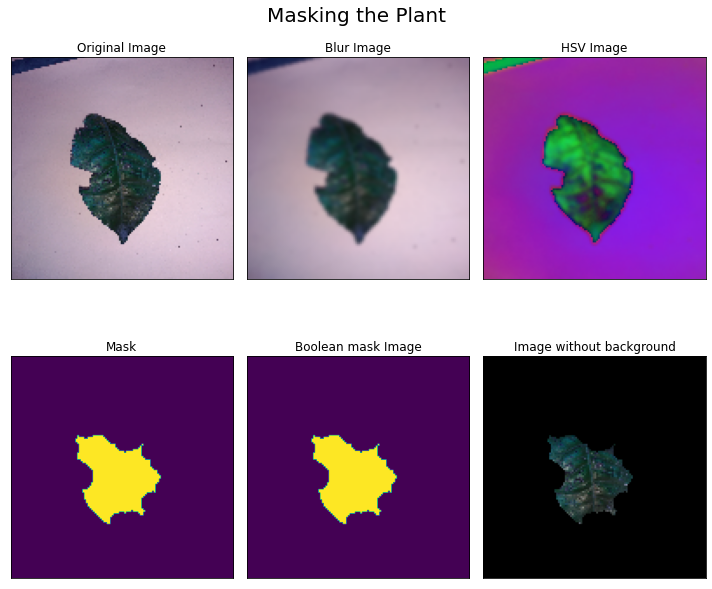

In [17]:
clearTrainImg1 = []
examples = []; getEx = True
plt.figure(figsize=(10,9))

for img in test_image:
    
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTrainImg1.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.xticks([]), plt.yticks([]), plt.title("Original Image")
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.xticks([]), plt.yticks([]), plt.title("Blur Image")
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.xticks([]), plt.yticks([]), plt.title("HSV Image")
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.xticks([]), plt.yticks([]), plt.title("Mask")
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.xticks([]), plt.yticks([]), plt.title("Boolean mask Image")
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        plt.xticks([]), plt.yticks([]), plt.title("Image without background")
        getEx = False
plt.suptitle("Masking the Plant", fontsize=20)
plt.tight_layout()    

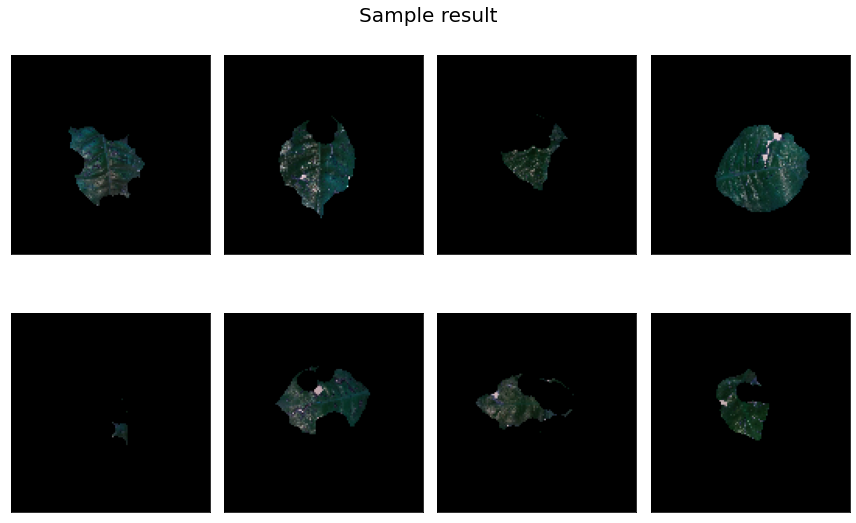

In [18]:
clearTrainImg1 = np.asarray(clearTrainImg1)
plt.figure(figsize=(12,8))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg1[i])
    plt.xticks([]), plt.yticks([])
    
plt.suptitle("Sample result", fontsize=20)  
plt.tight_layout()
plt.show()

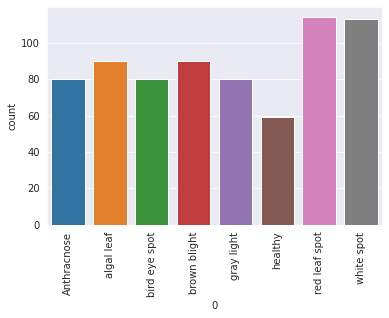

In [19]:
classes = list(INV_CLASS.values())

sns.set_style('darkgrid')  
ax = sns.countplot(x=0, data=pd.DataFrame(train_label))
ax.set_xticklabels(classes)

plt.xticks(rotation=90)
plt.show()

In [20]:
x_train = clearTrainImg / 255
x_test = clearTrainImg1 / 255

In [21]:
y_train=train_label
y_test=test_label

In [22]:
x_train=x_train.astype('float32') 
x_test=x_test.astype('float32')

In [23]:
from tensorflow.keras.optimizers import SGD

**Data Augmentation**

In [24]:
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(x_train)

**Model with 59% on training datset and 67% on test dataset**

In [25]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    #tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(256, activation='relu'),
    # 5 output neurons for 5 classes with the softmax activation
    tf.keras.layers.Dense(8, activation='softmax')
])

model.summary()

from tensorflow.keras.optimizers import RMSprop

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 64)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [26]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

In [26]:
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=32),epochs=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


23/23 [==============================] - 13s 538ms/step - loss: 1.9755 - acc: 0.1586
Epoch 2/100
23/23 [==============================] - 13s 569ms/step - loss: 1.8703 - acc: 0.2465
Epoch 3/100
23/23 [==============================] - 13s 541ms/step - loss: 1.7784 - acc: 0.2975
Epoch 4/100
23/23 [==============================] - 14s 607ms/step - loss: 1.6816 - acc: 0.3470
Epoch 5/100
23/23 [==============================] - 13s 541ms/step - loss: 1.6424 - acc: 0.3428
Epoch 6/100
23/23 [==============================] - 13s 543ms/step - loss: 1.5857 - acc: 0.3286
Epoch 7/100
23/23 [==============================] - 13s 544ms/step - loss: 1.5613 - acc: 0.3711
Epoch 8/100
23/23 [==============================] - 13s 544ms/step - loss: 1.4990 - acc: 0.3895
Epoch 9/100
23/23 [==============================] - 13s 543ms/step - loss: 1.4644 - acc: 0.3994
Epoch 10/100
23/23 [==============================] - 13s 544ms/step - loss: 1.4284 - acc: 0.4037
Epoch 11/100
23/23 [=====================

In [27]:
model.evaluate(x_test,y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 1s 126ms/step - loss: 0.8102 - acc: 0.6739


[0.810214638710022, 0.6739130616188049]

**Model 1 with accuracy of 98.5% on training data and 77% on test data hence there is problem of overfitting**

In [32]:
import tensorflow as tf

model1 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    #tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(256, activation='relu'),
    # 5 output neurons for 5 classes with the softmax activation
    tf.keras.layers.Dense(8, activation='softmax')
])

model1.summary()

from tensorflow.keras.optimizers import RMSprop

model1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 63, 63, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 64)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [33]:
model1.fit(x_train,y_train,epochs=100)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


23/23 [==============================] - 11s 454ms/step - loss: 1.8759 - acc: 0.2592
Epoch 2/100
23/23 [==============================] - 10s 452ms/step - loss: 1.6237 - acc: 0.3584
Epoch 3/100
23/23 [==============================] - 12s 538ms/step - loss: 1.4969 - acc: 0.4093
Epoch 4/100
23/23 [==============================] - 11s 475ms/step - loss: 1.4075 - acc: 0.4660
Epoch 5/100
23/23 [==============================] - 11s 463ms/step - loss: 1.3703 - acc: 0.4901
Epoch 6/100
23/23 [==============================] - 10s 451ms/step - loss: 1.3016 - acc: 0.4844
Epoch 7/100
23/23 [==============================] - 10s 451ms/step - loss: 1.2531 - acc: 0.5113
Epoch 8/100
23/23 [==============================] - 12s 527ms/step - loss: 1.1883 - acc: 0.5425
Epoch 9/100
23/23 [==============================] - 10s 454ms/step - loss: 1.1767 - acc: 0.5397
Epoch 10/100
23/23 [==============================] - 10s 453ms/step - loss: 1.1091 - acc: 0.5822
Epoch 11/100
23/23 [=====================

In [35]:
model1.evaluate(x_test,y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 1s 269ms/step - loss: 1.2984 - acc: 0.7717


[1.2983824014663696, 0.77173912525177]

**Using pretrained model mobilenet due problem of overfitting and less accuracy**

In [36]:
ALPHA = 1.0

mnet = MobileNet(input_shape=(128,128,3), include_top=False, alpha=ALPHA)


17235968/17225924 [==============================] - 0s 0us/step


In [38]:
tf.keras.backend.clear_session()

for layers in mnet.layers:
       layers.trainable = False

model3 = Sequential([mnet,
                     Flatten(),
                    
                     Dense(256, activation='relu'),
                     BatchNormalization(),
                     Dropout(0.5),
                   
                     Dense(256, activation='relu'),
                     BatchNormalization(),
                     Dropout(0.5),
                    
                    Dense(8,activation='softmax')])

model3.summary()

# # compile model
model3.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='RMSprop',
              metrics=['acc'])           

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 256)               4194560   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               6

In [39]:
model3.fit(x_train,y_train,epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


23/23 [==============================] - 10s 323ms/step - loss: 2.1280 - acc: 0.3598
Epoch 2/10
23/23 [==============================] - 7s 321ms/step - loss: 1.2996 - acc: 0.5453
Epoch 3/10
23/23 [==============================] - 7s 322ms/step - loss: 1.1075 - acc: 0.6161
Epoch 4/10
23/23 [==============================] - 7s 323ms/step - loss: 0.8602 - acc: 0.7153
Epoch 5/10
23/23 [==============================] - 7s 325ms/step - loss: 0.8101 - acc: 0.7238
Epoch 6/10
23/23 [==============================] - 7s 324ms/step - loss: 0.7020 - acc: 0.7564
Epoch 7/10
23/23 [==============================] - 7s 324ms/step - loss: 0.5253 - acc: 0.8074
Epoch 8/10
23/23 [==============================] - 7s 323ms/step - loss: 0.5003 - acc: 0.8144
Epoch 9/10
23/23 [==============================] - 7s 325ms/step - loss: 0.4167 - acc: 0.8598
Epoch 10/10
23/23 [==============================] - 9s 374ms/step - loss: 0.3610 - acc: 0.8768


In [40]:
model3.evaluate(x_test,y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 1s 294ms/step - loss: 0.8421 - acc: 0.7283


[0.8420745134353638, 0.72826087474823]

In [41]:
pred = model.predict(clearTrainImg1)
predNum = np.argmax(pred, axis=1)

In [43]:
files='/content/Images/test'

In [44]:
testId = []
for i in files:
    testId.append(i.split('/')[-1]) 

In [45]:
predStr=[]
for i in predNum:
    predStr.append(INV_CLASS[i])

**Output of Prediction**

In [49]:
predStr

['red leaf spot',
 'red leaf spot',
 'gray light',
 'gray light',
 'brown blight',
 'red leaf spot',
 'brown blight',
 'gray light',
 'gray light',
 'gray light',
 'brown blight',
 'brown blight',
 'brown blight',
 'brown blight',
 'brown blight',
 'brown blight',
 'brown blight',
 'brown blight',
 'red leaf spot',
 'brown blight',
 'brown blight',
 'brown blight',
 'brown blight',
 'brown blight',
 'brown blight',
 'brown blight',
 'brown blight',
 'brown blight',
 'brown blight',
 'brown blight',
 'brown blight',
 'brown blight',
 'brown blight',
 'brown blight',
 'healthy',
 'healthy',
 'brown blight',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'brown blight',
 'brown blight',
 'white spot',
 'brown blight',
 'brown blight',
 'brown blight',
 'red leaf spot',
 'brown blight',
 'brown blight',
 'brown blight',
 'red leaf spot',
 'red leaf spot',
 'brown blight',
 'white spot',
 'white spot',
 'red leaf spot',
 'brown blight',
 'red leaf spot',
 'red leaf spot',
 're

**For processing test datset**

In [ ]:
clearTestImg = []
examples = []; getEx = True
plt.figure(figsize=(10,9))

for img in testImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTestImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.xticks([]), plt.yticks([]), plt.title("Original Image")
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.xticks([]), plt.yticks([]), plt.title("Blur Image")
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.xticks([]), plt.yticks([]), plt.title("HSV Image")
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.xticks([]), plt.yticks([]), plt.title("Mask")
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.xticks([]), plt.yticks([]), plt.title("Boolean mask Image")
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        plt.xticks([]), plt.yticks([]), plt.title("Image without background")
        getEx = False

plt.suptitle("Masked Test Image", fontsize=20)
plt.tight_layout()
clearTestImg = np.asarray(clearTestImg)